## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

"""
建立實驗組合
"""
optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]
reduce_lr_factor = [0.99, 0.5, 0.1]
redice_lr_patient = [3,5,10]

In [9]:
import itertools

"""
以迴圈方式遍歷組合來訓練模型
"""
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.99, reduce_patient: 3
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

Epoch 11/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.2780 - accuracy: 0.5555 - val_loss: 1.4782 - val_accuracy: 0.4818
Epoch 12/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.2530 - accuracy: 0.5668 - val_loss: 1.4720 - val_accuracy: 0.4832
Epoch 13/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.2270 - accuracy: 0.5747 - val_loss: 1.4766 - val_accuracy: 0.4815
Epoch 14/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.2037 - accuracy: 0.5850 - val_loss: 1.4696 - val_accuracy: 0.4871
Epoch 15/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.1784 - accuracy: 0.5951 - val_loss: 1.4653 - val_accuracy: 0.4852
Epoch 16/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.1562 - accuracy: 0.6013 - val_loss: 1.4645 - val_accuracy: 0.4863
Epoch 17/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.1332 - accuracy: 0.6120 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 83us/step - loss: 2.2329 - accuracy: 0.2697 - val_loss: 2.1312 - val_accuracy: 0.2166
Epoch 2/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.7550 - accuracy: 0.3894 - val_loss: 1.9607 - val_accuracy: 0.3026
Epoch 3/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.6253 - accuracy: 0.4320 - val_loss: 1.8031 - val_accuracy: 0.3751
Epoch 4/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.5500 - accuracy: 0.4570 - val_loss: 1.7213 - val_accuracy: 0.4051
Epoch 5/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.4946 - accuracy: 0.4787 - val_loss: 1.6438 - val_accuracy: 0.4221
Epoch 6/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.4462 - accuracy: 0.4939 - val_loss: 1.5892 - val_accuracy: 0.4428
Epoch 7/25
50000/50000 [==============================] - 4s 75us/st

50000/50000 [==============================] - 4s 78us/step - loss: 1.2294 - accuracy: 0.5757 - val_loss: 1.4927 - val_accuracy: 0.4746
Epoch 21/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.2147 - accuracy: 0.5804 - val_loss: 1.4938 - val_accuracy: 0.4773
Epoch 22/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.1980 - accuracy: 0.5871 - val_loss: 1.4789 - val_accuracy: 0.4815
Epoch 23/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.1845 - accuracy: 0.5933 - val_loss: 1.4780 - val_accuracy: 0.4846
Epoch 24/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.1684 - accuracy: 0.5978 - val_loss: 1.4797 - val_accuracy: 0.4827
Epoch 25/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.1550 - accuracy: 0.6038 - val_loss: 1.4749 - val_accuracy: 0.4879
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
Model: "model_6"
________________________________________________

Epoch 5/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.6093 - accuracy: 0.4344 - val_loss: 1.7070 - val_accuracy: 0.4027
Epoch 6/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.5657 - accuracy: 0.4515 - val_loss: 1.6564 - val_accuracy: 0.4171
Epoch 7/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.5289 - accuracy: 0.4641 - val_loss: 1.6246 - val_accuracy: 0.4294
Epoch 8/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.4970 - accuracy: 0.4777 - val_loss: 1.5952 - val_accuracy: 0.4369
Epoch 9/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.4674 - accuracy: 0.4874 - val_loss: 1.5756 - val_accuracy: 0.4432
Epoch 10/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.4420 - accuracy: 0.4973 - val_loss: 1.5615 - val_accuracy: 0.4470
Epoch 11/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.4192 - accuracy: 0.5062 - val_loss:

50000/50000 [==============================] - 3s 66us/step - loss: 1.1642 - accuracy: 0.6029 - val_loss: 1.4686 - val_accuracy: 0.4802
Numbers of exp: 8, reduce_factor: 0.10, reduce_patient: 10
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
______________________________________________________________

Epoch 10/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.0081 - accuracy: 0.6466 - val_loss: 2.0163 - val_accuracy: 0.3624

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009900000470224768.
Epoch 11/25
50000/50000 [==============================] - 4s 83us/step - loss: 0.9666 - accuracy: 0.6627 - val_loss: 2.2007 - val_accuracy: 0.3310
Epoch 12/25
50000/50000 [==============================] - 4s 78us/step - loss: 0.9385 - accuracy: 0.6700 - val_loss: 1.7744 - val_accuracy: 0.4220
Epoch 13/25
50000/50000 [==============================] - 4s 77us/step - loss: 0.8954 - accuracy: 0.6861 - val_loss: 1.9887 - val_accuracy: 0.3706

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.000980100086890161.
Epoch 14/25
50000/50000 [==============================] - 4s 79us/step - loss: 0.8562 - accuracy: 0.7005 - val_loss: 1.7569 - val_accuracy: 0.4421
Epoch 15/25
50000/50000 [==============================] - 4s 78us/step - loss: 0.8200 - accuracy: 

50000/50000 [==============================] - 4s 79us/step - loss: 0.6387 - accuracy: 0.7777 - val_loss: 1.8450 - val_accuracy: 0.4611
Numbers of exp: 11, reduce_factor: 0.99, reduce_patient: 10
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_34 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_35 (Batc (None, 256)               1024      
____________________________________________________________

50000/50000 [==============================] - 4s 90us/step - loss: 1.2060 - accuracy: 0.5733 - val_loss: 1.6340 - val_accuracy: 0.4416
Epoch 10/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.1698 - accuracy: 0.5854 - val_loss: 1.4827 - val_accuracy: 0.4741

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0004521911032497883.
Epoch 11/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.0971 - accuracy: 0.6144 - val_loss: 1.4017 - val_accuracy: 0.5065
Epoch 12/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.0661 - accuracy: 0.6242 - val_loss: 1.4497 - val_accuracy: 0.4937
Epoch 13/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.0437 - accuracy: 0.6331 - val_loss: 1.4332 - val_accuracy: 0.5027
Epoch 14/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.0189 - accuracy: 0.6408 - val_loss: 1.4018 - val_accuracy: 0.5095

Epoch 00014: ReduceLROnPlateau reducing le

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.9302 - accuracy: 0.3464 - val_loss: 2.0821 - val_accuracy: 0.2571
Epoch 2/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.5899 - accuracy: 0.4439 - val_loss: 1.9237 - val_accuracy: 0.3002
Epoch 3/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.4939 - accuracy: 0.4802 - val_loss: 1.7562 - val_accuracy: 0.3924
Epoch 4/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.4336 - accuracy: 0.5016 - val_loss: 1.6430 - val_accuracy: 0.4321
Epoch 5/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.3851 - accuracy: 0.5210 - val_loss: 1.5724 - val_accuracy: 0.4522
Epoch 6/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.3429 - accuracy: 0.5347 - val_loss: 1.5275 - val_accuracy: 0.4642
Epoch 7/25
50000/50000 [==============================] - 4s 87us/s

Epoch 20/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.1054 - accuracy: 0.6275 - val_loss: 1.4169 - val_accuracy: 0.5021

Epoch 00020: ReduceLROnPlateau reducing learning rate to 2.826194247518288e-08.
Epoch 21/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.1055 - accuracy: 0.6287 - val_loss: 1.4171 - val_accuracy: 0.5014
Epoch 22/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.1061 - accuracy: 0.6279 - val_loss: 1.4172 - val_accuracy: 0.5016
Epoch 23/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.1048 - accuracy: 0.6276 - val_loss: 1.4173 - val_accuracy: 0.5017

Epoch 00023: ReduceLROnPlateau reducing learning rate to 2.826194211991151e-09.
Epoch 24/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.1053 - accuracy: 0.6284 - val_loss: 1.4173 - val_accuracy: 0.5017
Epoch 25/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.1058 - accuracy:

50000/50000 [==============================] - 5s 91us/step - loss: 2.9342 - accuracy: 0.1088 - val_loss: 2.3573 - val_accuracy: 0.0850
Epoch 2/25
50000/50000 [==============================] - 4s 79us/step - loss: 2.9341 - accuracy: 0.1094 - val_loss: 2.3566 - val_accuracy: 0.0911
Epoch 3/25
50000/50000 [==============================] - 4s 74us/step - loss: 2.9347 - accuracy: 0.1091 - val_loss: 2.3991 - val_accuracy: 0.0997
Epoch 4/25
50000/50000 [==============================] - 4s 72us/step - loss: 2.9350 - accuracy: 0.1091 - val_loss: 2.4558 - val_accuracy: 0.1044
Epoch 5/25
50000/50000 [==============================] - 5s 91us/step - loss: 2.9341 - accuracy: 0.1091 - val_loss: 2.5131 - val_accuracy: 0.1072
Epoch 6/25
50000/50000 [==============================] - 4s 80us/step - loss: 2.9339 - accuracy: 0.1083 - val_loss: 2.5683 - val_accuracy: 0.1079
Epoch 7/25
50000/50000 [==============================] - 4s 75us/step - loss: 2.9334 - accuracy: 0.1093 - val_loss: 2.6212 - val

50000/50000 [==============================] - 3s 69us/step - loss: 0.7745 - accuracy: 0.7294 - val_loss: 1.9569 - val_accuracy: 0.4310

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0009702991275116801.
Epoch 21/25
50000/50000 [==============================] - 3s 69us/step - loss: 0.7532 - accuracy: 0.7384 - val_loss: 1.8982 - val_accuracy: 0.4391
Epoch 22/25
50000/50000 [==============================] - 3s 68us/step - loss: 0.7210 - accuracy: 0.7483 - val_loss: 1.7923 - val_accuracy: 0.4526
Epoch 23/25
50000/50000 [==============================] - 3s 69us/step - loss: 0.7051 - accuracy: 0.7548 - val_loss: 1.6779 - val_accuracy: 0.4864
Epoch 24/25
50000/50000 [==============================] - 3s 68us/step - loss: 0.6761 - accuracy: 0.7667 - val_loss: 2.0066 - val_accuracy: 0.4201
Epoch 25/25
50000/50000 [==============================] - 3s 68us/step - loss: 0.6513 - accuracy: 0.7728 - val_loss: 2.0025 - val_accuracy: 0.4275
Numbers of exp: 19, reduce_factor: 0.99, re

50000/50000 [==============================] - 3s 68us/step - loss: 1.4297 - accuracy: 0.4943 - val_loss: 1.8629 - val_accuracy: 0.3365
Epoch 4/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.3592 - accuracy: 0.5228 - val_loss: 1.9698 - val_accuracy: 0.3607
Epoch 5/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.2911 - accuracy: 0.5462 - val_loss: 1.9312 - val_accuracy: 0.3553
Epoch 6/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.2391 - accuracy: 0.5641 - val_loss: 1.7842 - val_accuracy: 0.3753
Epoch 7/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.1959 - accuracy: 0.5792 - val_loss: 1.8941 - val_accuracy: 0.3697
Epoch 8/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.1581 - accuracy: 0.5931 - val_loss: 2.0971 - val_accuracy: 0.3587
Epoch 9/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.1141 - accuracy: 0.6071 - val_loss: 1.7650 - val

50000/50000 [==============================] - 3s 68us/step - loss: 0.6093 - accuracy: 0.8066 - val_loss: 1.4237 - val_accuracy: 0.5297
Epoch 22/25
50000/50000 [==============================] - 3s 68us/step - loss: 0.5965 - accuracy: 0.8101 - val_loss: 1.4190 - val_accuracy: 0.5357
Epoch 23/25
50000/50000 [==============================] - 3s 68us/step - loss: 0.5838 - accuracy: 0.8142 - val_loss: 1.4658 - val_accuracy: 0.5219

Epoch 00023: ReduceLROnPlateau reducing learning rate to 5.9436886658659205e-05.
Epoch 24/25
50000/50000 [==============================] - 3s 68us/step - loss: 0.5577 - accuracy: 0.8283 - val_loss: 1.4193 - val_accuracy: 0.5347
Epoch 25/25
50000/50000 [==============================] - 3s 68us/step - loss: 0.5506 - accuracy: 0.8308 - val_loss: 1.4227 - val_accuracy: 0.5360
Numbers of exp: 22, reduce_factor: 0.50, reduce_patient: 5
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape      

Epoch 5/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.5894 - accuracy: 0.4469 - val_loss: 1.7190 - val_accuracy: 0.3945
Epoch 6/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.5389 - accuracy: 0.4607 - val_loss: 1.6648 - val_accuracy: 0.4173
Epoch 7/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.4950 - accuracy: 0.4776 - val_loss: 1.6262 - val_accuracy: 0.4297
Epoch 8/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.4578 - accuracy: 0.4919 - val_loss: 1.6092 - val_accuracy: 0.4321
Epoch 9/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.4234 - accuracy: 0.5043 - val_loss: 1.5967 - val_accuracy: 0.4325
Epoch 10/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.3939 - accuracy: 0.5143 - val_loss: 1.5662 - val_accuracy: 0.4444
Epoch 11/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.3659 - accuracy: 0.5257 - val_loss:

50000/50000 [==============================] - 3s 70us/step - loss: 1.0962 - accuracy: 0.6331 - val_loss: 1.5084 - val_accuracy: 0.4776
Numbers of exp: 25, reduce_factor: 0.10, reduce_patient: 5
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_76 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_77 (Batc (None, 256)               1024      
_____________________________________________________________

Epoch 10/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.3839 - accuracy: 0.5209 - val_loss: 1.5801 - val_accuracy: 0.4392
Epoch 11/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.3571 - accuracy: 0.5309 - val_loss: 1.5567 - val_accuracy: 0.4504
Epoch 12/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.3324 - accuracy: 0.5404 - val_loss: 1.5596 - val_accuracy: 0.4539
Epoch 13/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.3076 - accuracy: 0.5492 - val_loss: 1.5451 - val_accuracy: 0.4601
Epoch 14/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.2854 - accuracy: 0.5584 - val_loss: 1.5357 - val_accuracy: 0.4646
Epoch 15/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.2646 - accuracy: 0.5676 - val_loss: 1.5333 - val_accuracy: 0.4602
Epoch 16/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.2430 - accuracy: 0.5750 - val_

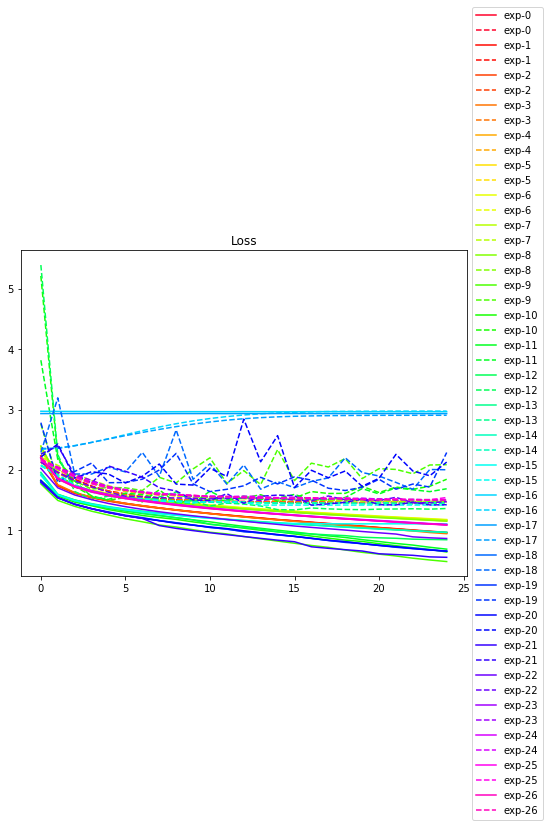

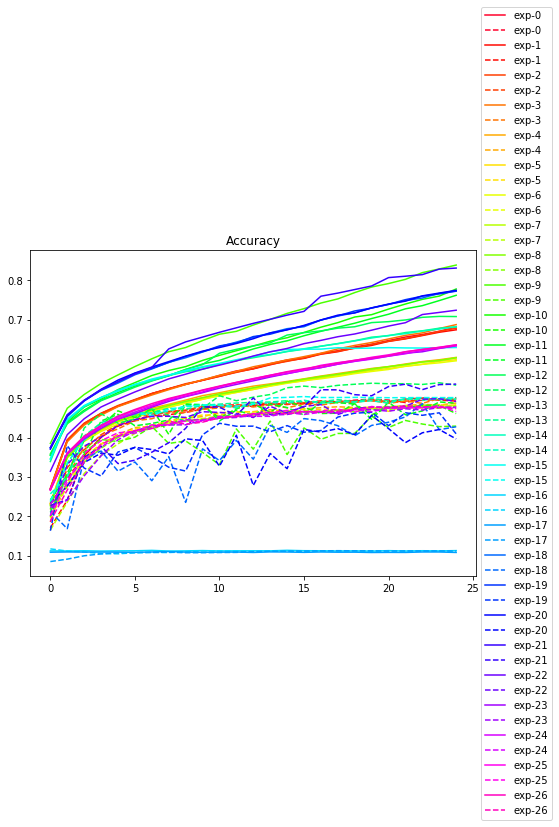

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()